# Check distribution of likelihood ratio against Wilk's theorem

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2

## Settings

In [60]:
n_samples_per_measurement = 500

## Data

In [61]:
filenames = [
    "alices_full_sgd1e1_grid",
    "calibrated_alices_full_grid60bins",
]
labels = ["Raw", "Calibrated"]

nmethods = len(filenames)


In [62]:
llrs = []
for filename in filenames:
    llrs.append(np.load("../data/results/llr_{}.npy".format(filename)))
llrs = np.array(llrs)
llrs = llrs.reshape(llrs.shape[0], llrs.shape[1], -1, n_samples_per_measurement)
llrs = np.sum(llrs, axis=3)

## Grid

In [63]:
def get_grid(resolution=25, fine=False):
    if fine:
        f_sub_1d = np.linspace(0.03, 0.07, resolution)
        beta_1d = np.linspace(-2.0, -1.8, resolution)
    else:
        f_sub_1d = np.linspace(0.001, 0.200, resolution)
        beta_1d = np.linspace(-2.5, -1.5, resolution)

    theta0, theta1 = np.meshgrid(f_sub_1d, beta_1d)
    theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T
    
    bin_size = f_sub_1d[1] - f_sub_1d[0]
    alpha_edges = np.linspace(f_sub_1d[0] - bin_size/2, f_sub_1d[-1] + bin_size/2, resolution + 1)
    bin_size = beta_1d[1] - beta_1d[0]
    beta_edges = np.linspace(beta_1d[0] - bin_size/2, beta_1d[-1] + bin_size/2, resolution + 1)
    
    return theta_grid, alpha_edges, beta_edges

In [64]:
theta_grid, alpha_edges, beta_edges = get_grid()

## Calculate likelihood ratio wrt best fit

In [65]:
idx_mle = np.argmax(llrs, axis=1)
theta_mle = theta_grid[idx_mle]

idx_true = 356
print(theta_grid[idx_true])
llr_true = llrs[:, idx_true, :]
llr_mle = np.max(llrs, axis=1)

q = -2. * (llr_true - llr_mle)

[ 0.05075    -1.91666667]


## Plot test statistic histo

In [66]:
qmin = 0.
qmax = 20.
qbins = 25


In [67]:
wilks = chi2.rvs(size=100000, df=2)

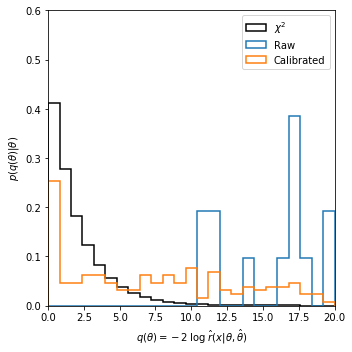

In [68]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()

plt.hist(
    wilks, range=(qmin, qmax), bins=qbins,
    histtype="step", density=True,
    lw=1.5, color="black",
    label=r"$\chi^2$"
)
for i in range(nmethods):
    plt.hist(
        q[i], range=(qmin, qmax), bins=qbins,
        histtype="step", density=True,
        lw=1.5, color="C{}".format(i),
        label=labels[i]
    )
    
plt.legend()
    
#ax.set_yscale("log")
plt.xlim(qmin, qmax)
plt.ylim(0., .6)

plt.xlabel(r"$q(\theta) = -2\; \log \; \hat{r}(x|\theta, \hat{\theta})$")
plt.ylabel(r"$p(q(\theta) | \theta)$")
    
plt.tight_layout()
plt.savefig("../figures/chi_squared.pdf")

## Plot MLE

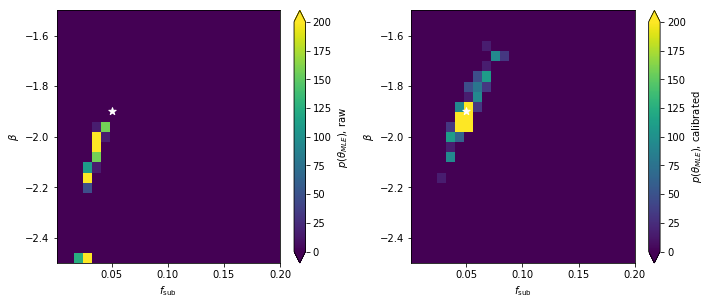

In [69]:
fig = plt.figure(figsize=(2 * 5, 2 * 4.))

for i in range(nmethods):
    ax = plt.subplot(2, 2, i+1)
    
    cm = plt.hist2d(
        theta_mle[i,:,0], theta_mle[i,:,1],
        bins=[25, 25],
        range=[[0.001,0.2], [-2.5,-1.5]],
        normed=True,
        norm=matplotlib.colors.Normalize(0., 200.),
        cmap="viridis"
    )[3]
    cbar = fig.colorbar(cm, ax=ax, extend='both', )
    cbar.set_label(r'$p(\theta_{MLE})$' + ', {}'.format(labels[i].lower()))
    plt.scatter(0.05, -1.9, s=60., color='white', marker='*')

    plt.xlabel(r'$f_{\mathrm{sub}}$')
    plt.ylabel(r'$\beta$')
    
plt.tight_layout()
plt.savefig("../figures/mle_distribution.pdf")